In [156]:
import os
import glob
import subprocess
import pandas as pd
import numpy as np
import cv2 

import affine
from osgeo import gdal 
import geopandas as gpd
from shapely import wkt

import rasterio as rio 
from rasterio import features
from rasterio.windows import Window
from rasterio.enums import ColorInterp 

import warnings 

class GeoPol_Change(): 
    def __init__(self, pngp=None, tifp=None, shpp=None, outp=None):
        self.pngp = pngp # png path
        self.tifp = tifp # tif path
        self.shpp = shpp # shapefile path
        self.outp = outp # output path

    def color_remove(self, tif):
        '''
        Replaces land, ocean, and boundary colors with white
        Boundaries are dissolved later on with geopandas
        '''
        # uses the bgr format 
        pb, gy, pb2, b, r , B, w = [244, 220, 182], [218, 217, 216], [249, 237, 217], [255, 0, 0], [0, 0, 255], [8, 7, 5], [255, 255, 255]
        colors = np.array([pb, gy, pb2, b, r, B]) # colors to remove
        img = cv2.imread(tif, cv2.IMREAD_UNCHANGED)
        mask = np.isin(img, colors).all(axis=-1)
        img[mask] = np.array(w)
        cv2.imwrite(tif, img)

    def set_geo_trans(self, tif, wf='GeoPol_ImageChange/B50_B59/B50-318.PGwx'): 
        '''
        Set geotransformation values
        Based on world file information
        https://gis.stackexchange.com/questions/131878/adding-origin-to-geotiff-using-python-gdal
        '''
        
        ds = gdal.Open(tif)

        ### manually setting world file 
        # geo_transform = [-15215756.744657781, 6806.6656849648989, 105.47907169670098, 
        #                     8471766.9069917351, 10.579092711745099, -6871.0052071305408] 
        # ds.SetGeoTransform(geo_transform)
 
        ### setting geotransform with world file *.PGwx
        with open(wf) as fp:
           A = affine.loadsw(fp.read())
        ds.SetGeoTransform(A.to_gdal())

    def convert_img(self, rename=False): 
        '''
        Converts pngs to geotiffs
        Eliminates colors and sets geotransformation
        '''

        for png in glob.iglob(os.path.join(self.pngp, '*PNG')):
            tif = os.path.join(self.tifp, os.path.basename(png.replace('.PNG','.TIFF')))

            if 'georef_' in png and rename: 
                tif = tif.replace('georef_','')

            # Sphere Robinson: 'ESRI:53030'
            # ! gdal_translate -of Gtiff -a_ullr 0 2400 1200 0 -a_srs ESRI:53030 png tif 
        
            gdal_translate_cmd = ['gdal_translate', '-of', 'Gtiff', 
                                  '-a_ullr', '0', '2400', '1200', '0', # attempt to fix shift
                                  '-a_srs', 'ESRI:53030', 
                                   png, tif]

            # subprocess.run(gdal_translate_cmd1)
            subprocess.run(gdal_translate_cmd)
            # removes colors
            self.color_remove(tif) 
            # sets transformation parameters
            self.set_geo_trans(tif)

    def color_assign(self, shape, src):
        '''
        Get bgr value from bands of pixel corresponding to the coordinate center of shapes read from image 
        https://gis.stackexchange.com/questions/426213/find-pixel-value-from-geotiff-using-latitude-and-longitude
        https://stackoverflow.com/questions/60127026/python-how-do-i-get-the-pixel-values-from-an-geotiff-map-by-coordinate 
        '''
        colors = []
        shape = gpd.GeoDataFrame(shape, geometry='geometry', crs='ESRI:53030')

        for geom in shape['geometry']:
            try:
                # find centriod and assign color 
                lon, lat = geom.centroid.y, geom.centroid.x
                # to pixel coordinate
                row, col = rio.transform.rowcol(src.transform, lat, lon)  #src.transform, lat, lon) 
                # set window to pixel coordinates
                w = Window(col, row, 1, 1)
                # read band colors from pixel data bgr format
                b, g, r = (src.read(k, window=w) for k in (1, 2, 3))
                # save as rgb 
                colors.append("{} {} {}".format(b, g, r).replace("[[", "").replace("]]", ""))
                
            except Exception:
                colors.append(np.nan)

        # returns list for assignment 
        return colors

    def process_tif(self, tif):
        ### set color interpretation
        with rio.open(tif, 'r+') as src:
            src.colorinterp = [ColorInterp.red, ColorInterp.green, ColorInterp.blue]
        
        bgr = ['b','g','r'] # used for specifying bgr columns
        with rio.open(tif) as src:
            polygons = []
            ### read shape by band then concat
            for k in (1, 2, 3):
                band = src.read(k)
                shapes = features.shapes(band, mask=None, transform=src.transform, connectivity=8)
                fc = [{"geometry": shape, "properties": {"value": value}} for shape, value in shapes]
                shape = gpd.GeoDataFrame.from_features(fc)
                shape = shape.rename(columns={"value":bgr[k-1]})
                polygons.append(shape)
            gdf = pd.concat(polygons)
            ### add id column
            gdf['id'] = os.path.basename(tif)[:3]
            ### remove the largest polygon 
            gdf = gpd.GeoDataFrame(gdf)
            ### overlap geometries compare between bgr columns
            gdf['bgr'] = self.color_assign(gdf, src)
            ### 
            # gdf["wtk"] = gdf.apply(lambda x: x.geometry.wkt, axis=1) 
            # gdf = gdf.dissolve(by="wtk") # dissolve identical geometries
            # adding to mask to remove white-associated colors 
            m = gdf[gdf[['b', 'g', 'r']].isin([255.0, np.nan]).all(axis=1)]
            m = m[m['bgr'] == '255 255 255']
            # remove white color
            gdf = gdf.drop(m.index)
            
        return gdf

    def save_shape(self):
        store = [] 
        for tif in glob.glob(os.path.join(self.tifp, '*TIFF')): 
            store.append(self.process_tif(tif))
        df = pd.concat(store).sort_values(by='id')
        return df

    def find_change(self, csv=None): 
        '''
        compare ids successively
        save geometry of intersection by rgb value
        '''

        # call shape reading function
        if csv==None: 
            df = self.save_shape()
        else: 
            df = pd.read_csv(csv)
            df['geometry'] = df['geometry'].apply(wkt.loads) 

        # convert back into geodataframe
        id_list = df['id'].unique()

        ### create successive ids
        for i in range(len(id_list)-1): 
            # create dfs for successive comparison
            df1 = df[df['id'] == id_list[i]]
            df2 = df[df['id'] == id_list[i+1]]

            gdf1 = gpd.GeoDataFrame(df1, geometry='geometry', crs='ESRI:53030')
            gdf2 = gpd.GeoDataFrame(df2, geometry='geometry', crs='ESRI:53030')

            ### find intersection and diff then combine
            diff = gpd.overlay(gdf2, gdf1, how='symmetric_difference', keep_geom_type=False)
            # gdf1 = gdf1.dissolve(by='bgr').reset_index() 
            # gdf2 = gdf2.dissolve(by='bgr').reset_index()
            ints = gpd.overlay(gdf2, gdf1, how='intersection', keep_geom_type=True)
            ints = ints[ints['bgr_2'] != ints['bgr_1']]

            result = pd.concat([diff, ints])
            # result = result.drop_duplicates(subset='geometry')

            # save to both csv and shapefile specify path
            out = os.path.join(self.outp, "{}_{}.csv".format(id_list[i],id_list[i+1]))
            # shp = os.path.join(self.shpp, "{}_{}".format(id_list[i],id_list[i+1]))
            # result.to_file(filename=shp, driver='ESRI Shapefile')
            result.to_csv(out, index=False)
            
    def csv_to_shp(self): 
        for csv in glob.glob(os.path.join(self.outp, '*csv')): 
            gdf = gpd.read_file(csv)
            shp = os.path.basename(shp.replace('.csv','.shp'))
            gdf.to_file(filename=shp, driver='ESRI Shapefile', crs_wkt='ESRI_WKT')


## current issues
+ polygons in legend 
+ 70km shift (output data)
```

In [ ]:
gp5 = GeoPol_Change(pngp='GeoPol_ImageChange/B50_B59', tifp='B50-B89/GeoTiff')
gp5.convert_img()
gp6 = GeoPol_Change(pngp='GeoPol_ImageChange/B60_B69', tifp='B50-B89/GeoTiff')
gp6.convert_img()
gp7 = GeoPol_Change(pngp='GeoPol_ImageChange/B70_B79', tifp='B50-B89/GeoTiff')
gp7.convert_img()
gp8 = GeoPol_Change(pngp='GeoPol_ImageChange/B80_B89', tifp='B50-B89/GeoTiff')
gp8.convert_img()

In [118]:
# warnings.filterwarnings("ignore")
gpb = GeoPol_Change(tifp='B50-B89/GeoTiff', outp='B50-B89/output', shpp='B50-B89/shapefile')
df = gpb.save_shape()
df.to_csv('B50-B89/output.csv')

In [ ]:
gpb = GeoPol_Change(tifp='B50-B89/GeoTiff', outp='B50-B89/output', shpp='B50-B89/shapefile')
gpb.find_change() # took 16 minutes 

In [11]:
df = pd.read_csv('B50-B89/output.csv')
len(df['bgr'].unique())

186

In [54]:
gpc = GeoPol_Change(tifp='C70-C90/geotiff', outp='C70-C90/out', shpp='C70-C90/shapefile')
# gpc.find_change()
df = gpc.save_shape()
df.to_csv('C70-C90/output.csv')
# gpc.convert_img(rename=True)

# Output visual test

In [119]:
import pandas as pd
import geopandas as gpd
import plotly.express as px 
from shapely import wkt

warnings.filterwarnings("ignore")

df = pd.read_csv('B50-B89/output.csv')
df['geometry'] = df['geometry'].apply(wkt.loads) 
# df = df.drop(df[df['rgb'] == '255 255 255'].index)
df = df.drop(columns=['Unnamed: 0'])

df1 = df[df['id'] == 'B50']
df2 = df[df['id'] == 'B51']
df = pd.concat([df1, df2])

df.head()

,geometry,b,g,r,id,bgr
0,POLYGON ((-11958398.037651137 8452780.48462934...,58.0,NaN,NaN,B50,58 0 0
1,POLYGON ((-15019363.612910949 5211702.38670159...,NaN,144.0,NaN,B50,58 144 219
2,POLYGON ((-15032976.94428088 5211681.228516173...,NaN,219.0,NaN,B50,255 219 144
3,POLYGON ((-14713274.615230924 5225920.45628788...,NaN,182.0,NaN,B50,255 255 255
4,POLYGON ((-14747307.943655748 5225867.56082432...,NaN,219.0,NaN,B50,255 219 144


In [120]:
dfw = df[df[['b', 'g', 'r']].isin([255.0, np.nan]).all(axis=1)]
dfw = dfw[dfw['bgr'] == '255 255 255']
dfw

,geometry,b,g,r,id,bgr


<Axes: >

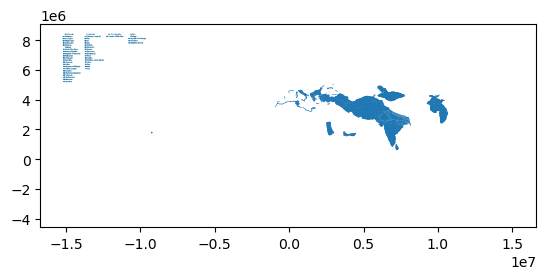

In [121]:
gdf1 = gpd.GeoDataFrame(df1, geometry='geometry', crs='ESRI:53030')
gdf2 = gpd.GeoDataFrame(df2, geometry='geometry', crs='ESRI:53030')
# gdf = gdf1.dissolve(by='rgb').reset_index()
gdf1.plot()

<Axes: >

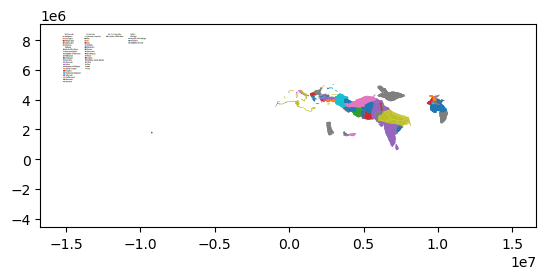

In [122]:
gdf1.plot(column='bgr', categorical=True)

<Axes: >

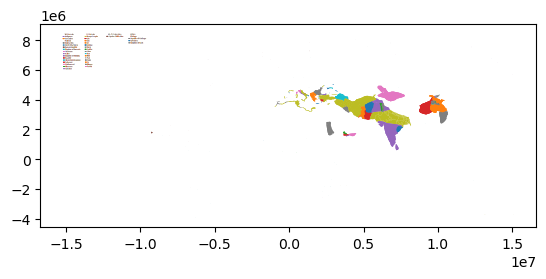

In [127]:
# gdf2 = gdf2.dissolve(by='bgr').reset_index()
gdf2.plot(column='bgr', categorical=True)

<Axes: >

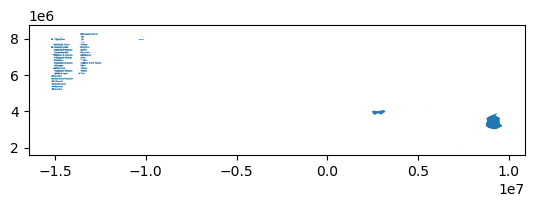

In [153]:
gdf1 = gpd.GeoDataFrame(df1, geometry='geometry', crs='ESRI:53030')
gdf2 = gpd.GeoDataFrame(df2, geometry='geometry', crs='ESRI:53030')
diff = gpd.overlay(gdf2, gdf1, how='symmetric_difference', keep_geom_type=False) #, how='union')
diff.plot()

<Axes: >

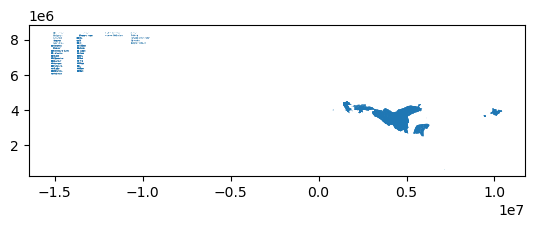

In [160]:
warnings.filterwarnings("ignore")
ints = gpd.overlay(gdf2, gdf1, how='intersection', keep_geom_type=True)
ints = ints[ints['bgr_2'] != ints['bgr_1']]
ints.plot()

# scratch


```python

gdf = pd.concat([d.set_index('geometry') for d in polygons], axis=1, join='outer').reset_index()

def convert_shp(self):
    '''
    tif to polygonized shapefile
    https://gis.stackexchange.com/questions/78001/gdal-polygonize-only-certain-raster-values
    https://gis.stackexchange.com/questions/329084/constructing-boundary-polygon-around-raster-image-when-mask-layer-is-ill-defined 
    '''

    for tif in glob.iglob(os.path.join(self.tifp, '*TIFF')):
        # ! gdal_polygonize.py GeoTiff/B50-318.TIFF shapefiles/B50.shp
        shp = os.path.join(self.shpp, os.path.basename(tif.replace('.TIFF','.shp')))
        gdal_polygon_cmd = ['gdal_polygonize.py', tif, shp]
        subprocess.run(gdal_polygon_cmd)

def old_compare(self):

    for tif in glob.iglob(os.path.join(self.tifp, '*TIFF')):
        # call shape reading function
        if csv==None: 
            df = self.save_shape()
        else: 
            df = pd.read_csv(csv)

        # convert back into geodataframe
        id_list = df['id'].unique()

        for i in range(len(id_list) - 1): 
            ### create successive ids
            # drop obsolete value column 
            df = df.drop(columns=['value'])
            # drop white color 
            df = df.drop(df[df['rgb'] == '255 255 255'].index)
            df['geomerty'] = df['geometry'].apply(wkt.loads) # resolves issue in this order
            # create dfs for successive comparison
            df1 = df[df['id'] == id_list[i]]
            df2 = df[df['id'] == id_list[i+1]]
            df = pd.concat([df1, df2]) # geometry is invalid 
            # df['geomerty'] = df['geometry'].apply(wkt.loads) # doesn't resolve issue
            gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='ESRI:53030')
            # dissolve geometry by shared colors 
            gdf = gdf.dissolve(by='rgb')
            # remove duplicate/identical geometries 
            gdf = gdf.dissolve('geometry')
            gdf.reset_index(drop=True, inplace=True)
            # filter by id again for comparison 
            gdf1 = gdf.loc[gdf['id'] == id_list[i]]
            gdf2 = gdf.loc[gdf['id'] == id_list[i+1]]
            # filter by id then overlay, intersect comparison 

            # https://stackoverflow.com/questions/70955598/removing-duplicate-geometries-using-two-unequal-geodataframes 
            # sjoin intersect to old area to unecessary old area geometries 
            # strip = gpd.sjoin(intersect, gdf1, how = 'inner', predicate = 'contains' )
            # result = intersect.drop(strip.index)  # returns geometry collection  
            gdf = gpd.overlay(gdf2, gdf1, how='intersection')

            # save to specified path
            path = os.path.join(self.outp, "{}_{}.csv".format(id_list[i],id_list[i+1]))
            pd.DataFrame(gdf).to_csv(path, index=False)
``

Geotransformation logic. [world files](https://webhelp.esri.com/arcims/9.3/General/topics/author_world_files.htm) and [gdal command reference](https://gdal.org/tutorials/geotransforms_tut.html#geotransforms-tut). 

>>>
    PNGs used contain supporting ESRI files.
    Supplied with world file. Same for all pngs. Used this order for geotransform.

    6806.6656849648989 = A = GT(1)
    10.579092711745099 = D = GT(4) or 2? 
    105.47907169670098 = B = GT(2) or 4?
    -6871.0052071305408 = E = GT(5)
    -15215756.744657781 = C = GT(0)
    8471766.9069917351 = F = GT(3)

    *Esri order*
    A = x-scale; dimension of a pixel in map units in x direction
    B,D = rotation terms
    C,F = translation terms; x,y map coordinates of the center of the upper-left pixel
    E = negative of y-scale; dimension of a pixel in map units in y direction

    *gdal geotransform*
    GT(0) x-coordinate of the upper-left corner of the upper-left pixel.
    GT(1) w-e pixel resolution / pixel width.
    GT(2) row rotation (typically zero).
    GT(3) y-coordinate of the upper-left corner of the upper-left pixel.
    GT(4) column rotation (typically zero).
    GT(5) n-s pixel resolution / pixel height (negative value for a north-up image).

>>>